Working directory set to: c:\Users\RXCHC\OneDrive\Documents\GitHub\ascent
'ascent' folder added to sys.path: c:\Users\RXCHC\OneDrive\Documents\GitHub\ascent
pygame 2.5.2 (SDL 2.28.3, Python 3.10.16)
Hello from the pygame community. https://www.pygame.org/contribute.html
Radius: 1868.3816528320312
Orientation: 15.800539428588786 degrees, 0.27577143662005776 radians
x: 1797.7856555235342, y: 508.7403438230241


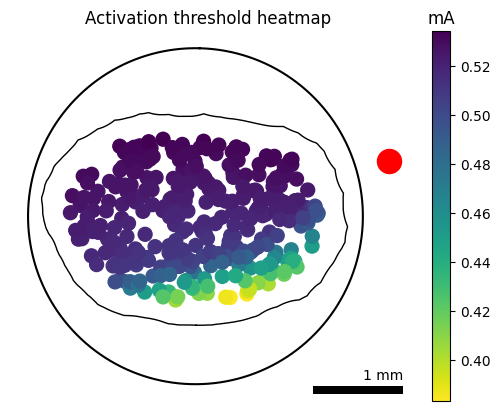

Radius: 1868.3816528320312
Orientation: 15.800539428588786 degrees, 0.27577143662005776 radians
x: 1797.7856555235342, y: 508.7403438230241


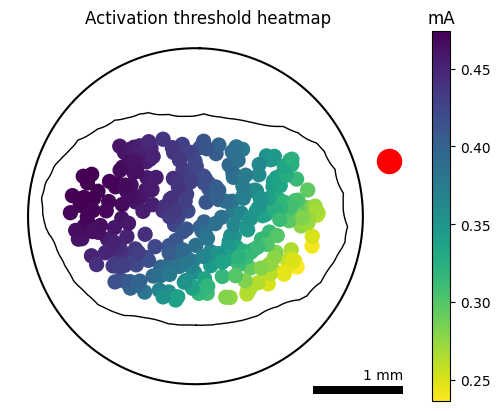

Radius: 1868.3816528320312
Orientation: 15.800539428588786 degrees, 0.27577143662005776 radians
x: 1797.7856555235342, y: 508.7403438230241


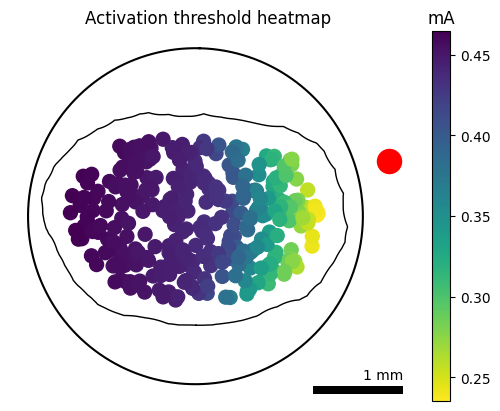

Radius: 1868.3816528320312
Orientation: 15.800539428588786 degrees, 0.27577143662005776 radians
x: 1797.7856555235342, y: 508.7403438230241


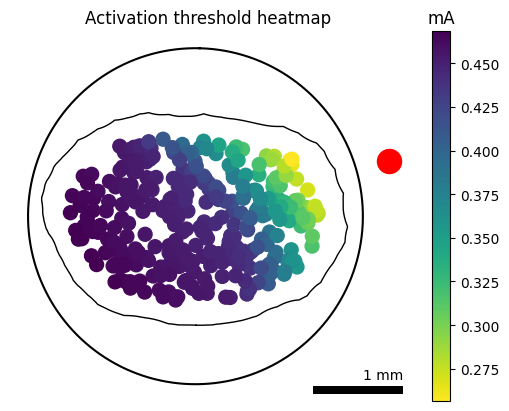

Radius: 1868.3816528320312
Orientation: 15.800539428588786 degrees, 0.27577143662005776 radians
x: 1797.7856555235342, y: 508.7403438230241


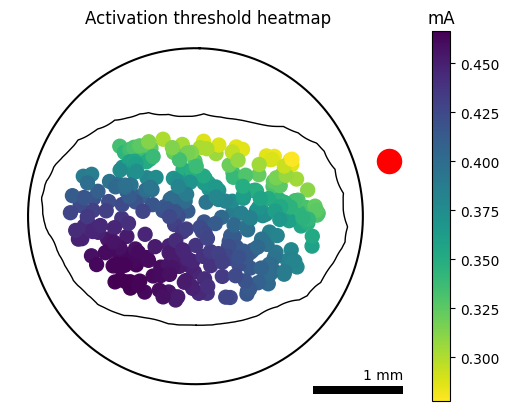

Radius: 1868.3816528320312
Orientation: 15.800539428588786 degrees, 0.27577143662005776 radians
x: 1797.7856555235342, y: 508.7403438230241


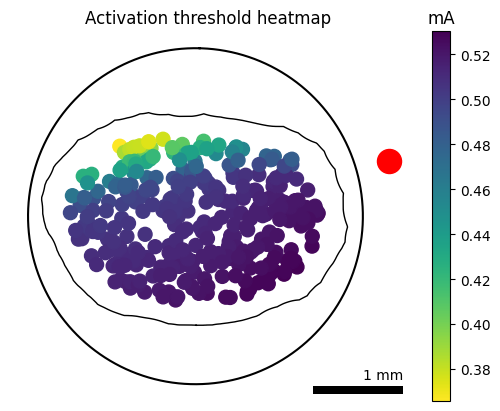

Radius: 1868.3816528320312
Orientation: 15.800539428588786 degrees, 0.27577143662005776 radians
x: 1797.7856555235342, y: 508.7403438230241


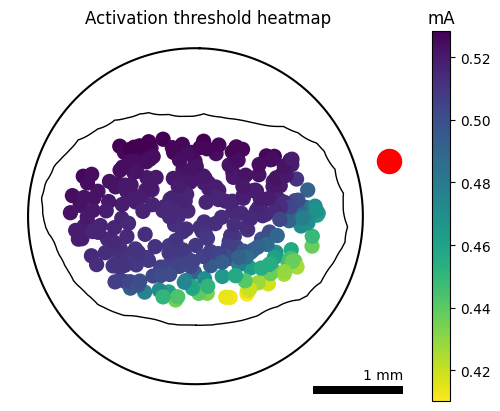

Radius: 1868.3816528320312
Orientation: 15.800539428588786 degrees, 0.27577143662005776 radians
x: 1797.7856555235342, y: 508.7403438230241


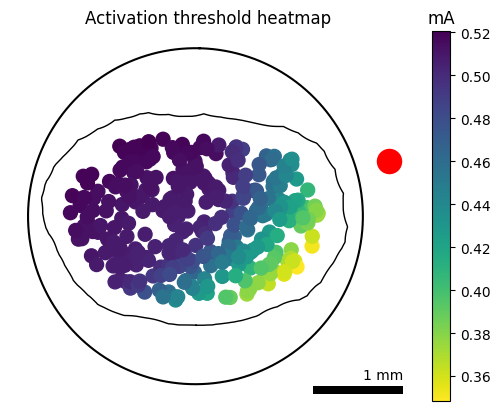

In [2]:
"""Generate a heatmap of activation thresholds.

The copyrights of this software are owned by Duke University.
Please refer to the LICENSE and README.md files for licensing instructions.
The source code can be found on the following GitHub repository: https://github.com/wmglab-duke/ascent.

Note: if more than one heatmap is desired, you must use a Seaborn FacetGrid.
RUN THIS FROM REPOSITORY ROOT
"""
%load_ext autoreload
%autoreload 2

import os
import sys

from notebook_setup import setup_notebook

# Call the setup function
setup_notebook()


import matplotlib.pyplot as plt

from src.core.plotter import heatmaps
from src.core.query import Query
# Initialize and run Querys
q = Query(
    {
        'partial_matches': True,
        'include_downstream': True,
        'indices': {'sample': [2], 'model': [0], 'sim': [5]},
        'model_filters': [lambda m: isinstance(m.get('cuff'), dict)]  # Only use dict-type cuffs
    }
).run()

# Build heatmap
data=q.threshold_data(ignore_missing=True)
# write filter logic particular examing how many n_sim and create a for loop to go through each of them

filtered_data = data[data['threshold'].notna()]
unique_nsim_values = filtered_data['nsim'].unique()
for nsim_value in unique_nsim_values:
    filtered_data2 = filtered_data[filtered_data['nsim'] == nsim_value]
    # heatmaps(data=filtered_data2)
    ax, meta_data =heatmaps(data=filtered_data2, return_metadata=True, cuff_orientation=True)
    plt.title('Activation threshold heatmap')
    plt.show()
    save_directory = os.path.join('out', 'analysis')
    os.makedirs(save_directory, exist_ok=True)
    plt.savefig(os.path.join(save_directory, f'threshold_heatmap_nsim_{nsim_value}.png'), dpi=400, bbox_inches='tight')
    plt.close()  # Close the figure to free up memory


In [3]:
import math

# def calculate_imthera_parameters(inner_radius_um):
#     """
#     Calculate parameters for an ImThera cuff with 6 contacts

#     Parameters:
#     inner_radius_um (float): Inner radius of the cuff in micrometers

#     Returns:
#     tuple: Six values in both radians and degrees:
#         1. Angle to first contact center (radians)
#         2. Angle to first contact center (degrees)
#         3. Angular spacing between contacts (radians)
#         4. Angular spacing between contacts (degrees)
#         5. Span of each contact (radians)
#         6. Span of each contact (degrees)
#     """
#     r_in_iti = inner_radius_um / 25400  # Convert to inches
#     r_cuff_in_pre_iti = 0.059  # inch (pre-expansion inner radius)
#     ang_cuffseam_contactcenter_pre_itc = 53  # degrees
#     ang_contactcenter_contactcenter_pre_itc = 51  # degrees

#     # Angle to first contact center
#     ang_first_contact_deg = ang_cuffseam_contactcenter_pre_itc * (r_cuff_in_pre_iti / r_in_iti)
#     ang_first_contact_rad = math.radians(ang_first_contact_deg)

#     # Angular spacing between contacts
#     ang_spacing_deg = ang_contactcenter_contactcenter_pre_itc * (r_cuff_in_pre_iti / r_in_iti)
#     ang_spacing_rad = math.radians(ang_spacing_deg)

#     # Span of each contact (assuming half the angular spacing)
#     contact_span_deg = ang_spacing_deg / 2
#     contact_span_rad = ang_spacing_rad / 2

#     return (
#         ang_first_contact_rad,
#         ang_first_contact_deg,
#         ang_spacing_rad,
#         ang_spacing_deg,
#         contact_span_rad,
#         contact_span_deg
#     )
def calculate_imthera_parameters(inner_radius_um):
    """
    Calculate parameters for an ImThera cuff with 6 contacts

    Parameters:
    inner_radius_um (float): Inner radius of the cuff in micrometers

    Returns:
    tuple: Six values in both radians and degrees:
        1. Angle to first contact center (radians)
        2. Angle to first contact center (degrees)
        3. Angular spacing between contacts (radians)
        4. Angular spacing between contacts (degrees)
        5. Span of each contact (radians)
        6. Span of each contact (degrees)
    """
    # Convert inner radius to inches
    r_in_iti = inner_radius_um / 25400  # Convert to inches
    
    # Constants from the original ImThera cuff design
    r_cuff_in_pre_iti = 0.059  # inch (pre-expansion inner radius)
    ang_cuffseam_contactcenter_pre_itc = 53  # degrees
    ang_contactcenter_contactcenter_pre_itc = 51  # degrees
    
    # Fixed contact diameter from ImThera_flip.json (2mm)
    contact_diameter_inch = 2 / 25.4  # Convert 2mm to inches

    # Angle to first contact center (scaled with radius)
    ang_first_contact_deg = ang_cuffseam_contactcenter_pre_itc * (r_cuff_in_pre_iti / r_in_iti)
    ang_first_contact_rad = math.radians(ang_first_contact_deg)

    # Angular spacing between contacts (scaled with radius)
    ang_spacing_deg = ang_contactcenter_contactcenter_pre_itc * (r_cuff_in_pre_iti / r_in_iti)
    ang_spacing_rad = math.radians(ang_spacing_deg)

    # Calculate span based on fixed contact diameter (2mm)
    # Arc length = radius × angle (in radians)
    # So angle (in radians) = arc length / radius
    # Where arc length = contact diameter
    contact_span_rad = contact_diameter_inch / r_in_iti
    contact_span_deg = math.degrees(contact_span_rad)

    return (
        ang_first_contact_rad,
        ang_first_contact_deg,
        ang_spacing_rad,
        ang_spacing_deg,
        contact_span_rad,
        contact_span_deg
    )
# Example usage with 1868 μm inner radius
inner_radius = meta_data['r_cuff'] # μm
results = calculate_imthera_parameters(inner_radius)

print(f"Angle to first contact center: {results[0]:.4f} radians, {results[1]:.4f} degrees")
print(f"Angular spacing between contacts: {results[2]:.4f} radians, {results[3]:.4f} degrees")
print(f"Span of each contact: {results[4]:.4f} radians, {results[5]:.4f} degrees")

meta_data["ang"]=results[2]
meta_data["deg_contact"]=results[5]

Angle to first contact center: 0.7419 radians, 42.5105 degrees
Angular spacing between contacts: 0.7139 radians, 40.9063 degrees
Span of each contact: 1.0704 radians, 61.3320 degrees


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.patches as mpatches

def plot_cuff(ax: plt.Axes, ax_ind: int, metadata: dict, contact_current_arrays=None, multi_color: bool = False):
    """
    Plot the cuff with contacts based on current distribution.
    
    :param ax: Matplotlib axis to plot on
    :param ax_ind: Index of the axis/plot
    :param metadata: Dictionary containing cuff parameters
    :param contact_current_arrays: List of arrays specifying current distribution across contacts
    :param multi_color: Whether to use different colors for different contacts
    :return: None
    """
    ang = metadata["ang"]
    const = metadata["const"]
    r_cuff = metadata["r_cuff"]
    cuff_shift_x = metadata["cuff_shift_x"]
    cuff_shift_y = metadata["cuff_shift_y"]
    deg_contact = metadata["deg_contact"]

    rot_def = np.arctan2(
        metadata["orientation_point_y"], metadata["orientation_point_x"]
    )
    ln_angs = [
        rot_def - 2.5 * ang - const,
        rot_def - 1.5 * ang - const,
        rot_def - 0.5 * ang - const,
        rot_def + 0.5 * ang - const,
        rot_def + 1.5 * ang - const,
        rot_def + 2.5 * ang - const,
    ]
    signs = [1, 1, 1, 1, 1, 1]
    contact_colors = ["red", "blue", "green", "orange", "purple", "teal"]

    # Draw the cuff (only once)
    cuff = mpatches.Arc(
        xy=(cuff_shift_x, cuff_shift_y),
        width=2 * r_cuff,
        height=2 * r_cuff,
        angle=0.0,
        theta1=0,
        theta2=360,
        color="gray",
        linewidth=1,
    )
    ax.add_artist(cuff)

    # If using current arrays, plot based on the distribution
    if contact_current_arrays is not None:
        array_index = min(int(ax_ind / 6), len(contact_current_arrays) - 1)
        current_array = contact_current_arrays[array_index]
        
        # Plot each contact based on its current value
        for s_ind, current in enumerate(current_array):
            if current > 0:  # Only plot contacts with current
                active_contact = mpatches.Arc(
                    xy=(cuff_shift_x, cuff_shift_y),
                    width=2 * r_cuff + signs[s_ind] * 220,
                    height=2 * r_cuff + signs[s_ind] * 220,
                    angle=0.0,
                    theta1=math.degrees(ln_angs[s_ind]) - deg_contact / 2,
                    theta2=math.degrees(ln_angs[s_ind]) + deg_contact / 2,
                    color=contact_colors[s_ind % len(contact_colors)] if multi_color else "red",
                    linewidth=4,
                    alpha=current  # Set alpha based on current proportion
                )
                ax.add_artist(active_contact)
    else:
        # Original behavior - plot single contact based on ax_ind
        s_ind = int(np.floor(ax_ind / 6))
        active_contact = mpatches.Arc(
            xy=(cuff_shift_x, cuff_shift_y),
            width=2 * r_cuff + signs[s_ind] * 220,
            height=2 * r_cuff + signs[s_ind] * 220,
            angle=0.0,
            theta1=math.degrees(ln_angs[s_ind]) - deg_contact / 2,
            theta2=math.degrees(ln_angs[s_ind]) + deg_contact / 2,
            color=contact_colors[s_ind % len(contact_colors)] if multi_color else "red",
            linewidth=4,
        )
        ax.add_artist(active_contact)
# Define the current distribution arrays
contact_current_arrays = [
    [1, 0, 0, 0, 0, 0],    # First contact only, 100% current
    [0, 1, 0, 0, 0, 0],    # Second contact only, 100% current
    [0, 0, 1, 0, 0, 0],    # Third contact only, 100% current
    [0, 0, 0, 1, 0, 0],    # Fourth contact only, 100% current
    [0, 0, 0, 0, 1, 0],    # Fifth contact only, 100% current
    [0, 0, 0, 0, 0, 1],    # Sixth contact only, 100% current
    [0.8, 0.2, 0, 0, 0, 0], # First contact 80%, second contact 20%
    [0.5, 0.5, 0, 0, 0, 0]  # First and second contacts 50% each
]

meta_data['const'] = 0.0


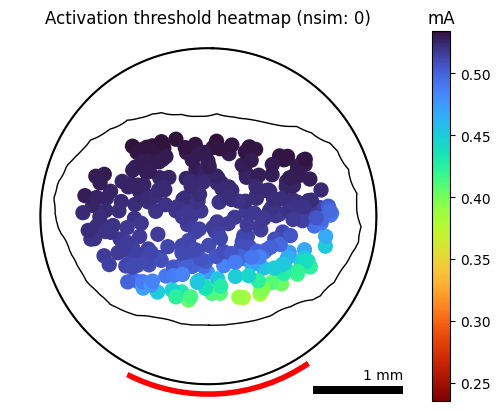

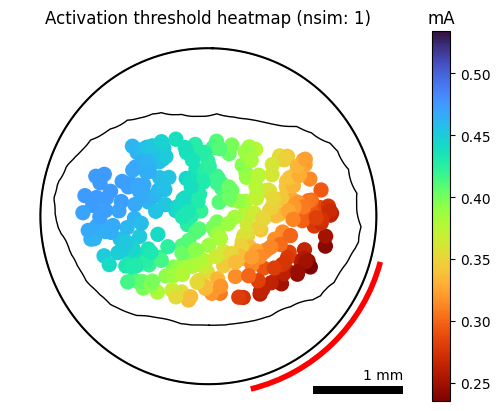

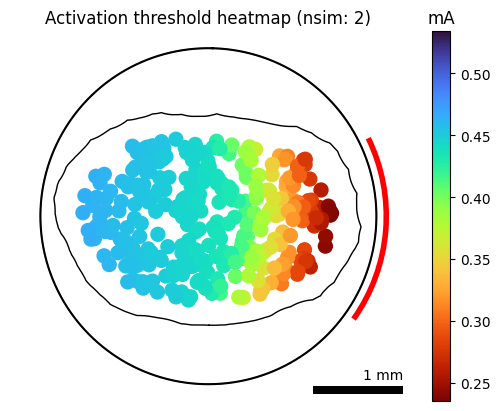

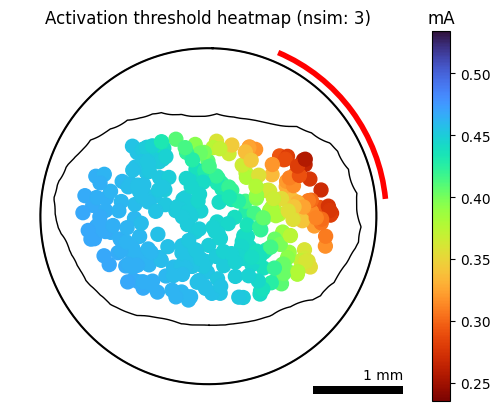

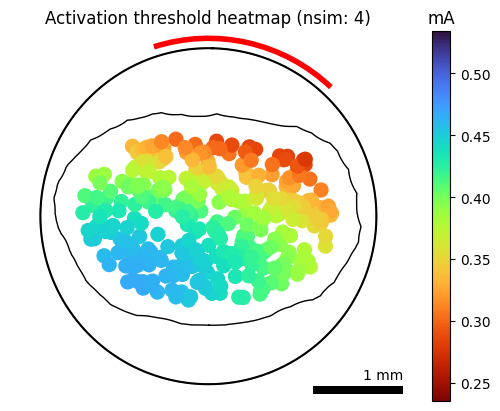

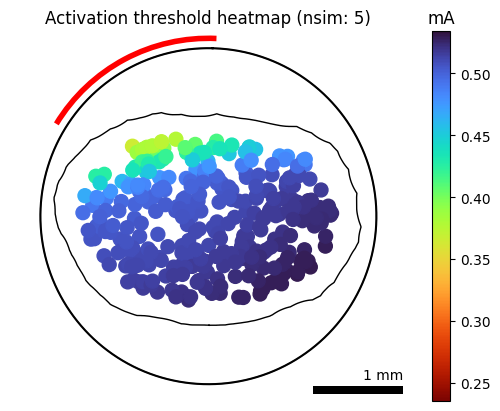

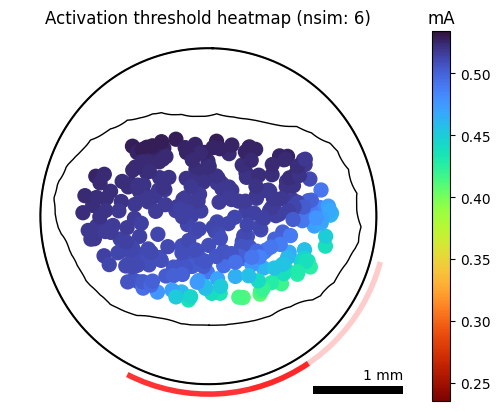

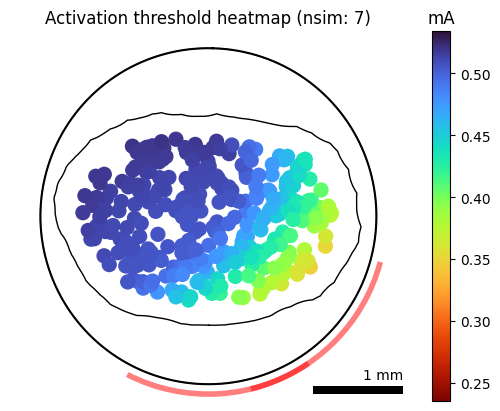

In [5]:
i=0
global_min = filtered_data['threshold'].min()
global_max = filtered_data['threshold'].max()
for nsim_value in unique_nsim_values:
    filtered_data2 = filtered_data[filtered_data['nsim'] == nsim_value]
    # heatmaps(data=filtered_data2)
    ax =heatmaps(data=filtered_data2, return_metadata=False, cuff_orientation=False, 
                 min_thresh=global_min, max_thresh=global_max, cmap=plt.cm.turbo.reversed())
    
    # heatmap_obj = ax.collections[0]
    # heatmap_obj.set_clim(0.42, 0.46)
    # cbar = ax.figure.colorbar(heatmap_obj)
    # cbar.mappable.set_clim(0.42, 0.46)
    
    plot_cuff(ax, i * 6, meta_data, contact_current_arrays)  # Multiply by 6 to ensure correct indexing logic
    i = i + 1
    plt.title(f'Activation threshold heatmap (nsim: {nsim_value})')
        
    save_directory = os.path.join('out', 'analysis')
    os.makedirs(save_directory, exist_ok=True)
    plt.savefig(os.path.join(save_directory, f'threshold_heatmap_nsim_{nsim_value}.png'), dpi=400, bbox_inches='tight')
    plt.show()
    plt.close()  #

In [10]:
import imageio
import glob
import os

# Path to your heatmap images
image_path = os.path.join('out', 'analysis')
images = []
filenames = sorted(glob.glob(os.path.join(image_path, 'threshold_heatmap_nsim_*.png')))

# Read all the images
for filename in filenames:
    images.append(imageio.imread(filename))

# Set the fps when creating the gif (lower value = slower animation)
fps = 1  # Adjust this value to control the speed

# Save as GIF with the specified fps
imageio.mimsave(os.path.join(image_path, 'threshold_heatmap_animation.gif'), 
                images, fps=fps)

C:\Users\RXCHC\AppData\Local\Temp\ipykernel_818068\3056380877.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
